<a href="https://colab.research.google.com/github/annaluizacaraciolo/DeepLearning2023/blob/main/Projeto_DangerousFarmInsects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from sklearn.model_selection import train_test_split
from google.colab import files

# Importando dataset

In [ ]:
! pip install -q kaggle
files.upload()

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download tarundalal/dangerous-insects-dataset

 98% 436M/447M [00:05<00:00, 111MB/s] 
100% 447M/447M [00:05<00:00, 86.0MB/s]


In [7]:
!unzip -q /content/dangerous-insects-dataset

# Armazenando o dataset

In [8]:
import pathlib
data = tf.keras.utils.image_dataset_from_directory("farm_insects", labels="inferred")
data_dir = pathlib.Path("farm_insects")

Found 1591 files belonging to 15 classes.


In [9]:
batch_size = 32
img_height = 224
img_width = 224

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1591 files belonging to 15 classes.
Using 1273 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1591 files belonging to 15 classes.
Using 318 files for validation.


A opção abaixo otimiza o treinamento ao deixar em memória os dados que forem utilizados na primeira epoch.
https://www.tensorflow.org/tutorials/images/classification?hl=pt-br#configure_the_dataset_for_performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Análise exploratória de dados

## Conhecendo o conjunto de dados

In [13]:
num_classes = len(data.class_names)
print("Number of classes:", num_classes)

Number of classes: 15


In [14]:
for species in data.class_names:
  class_name = species
  image_count = len(os.listdir('farm_insects/' + class_name))
  print(f"Class '{class_name}' has {image_count} images.")

Class 'Africanized Honey Bees (Killer Bees)' has 97 images.
Class 'Aphids' has 88 images.
Class 'Armyworms' has 96 images.
Class 'Brown Marmorated Stink Bugs' has 114 images.
Class 'Cabbage Loopers' has 104 images.
Class 'Citrus Canker' has 104 images.
Class 'Colorado Potato Beetles' has 112 images.
Class 'Corn Borers' has 115 images.
Class 'Corn Earworms' has 110 images.
Class 'Fall Armyworms' has 113 images.
Class 'Fruit Flies' has 101 images.
Class 'Spider Mites' has 119 images.
Class 'Thrips' has 109 images.
Class 'Tomato Hornworms' has 109 images.
Class 'Western Corn Rootworms' has 100 images.


A partir da análise de quantiade de imagens presentes nas amostras de cada classe, percebemos que o conjunto de dados trabalhado é bem distribuído.

## Visualizando o conjunto de dados

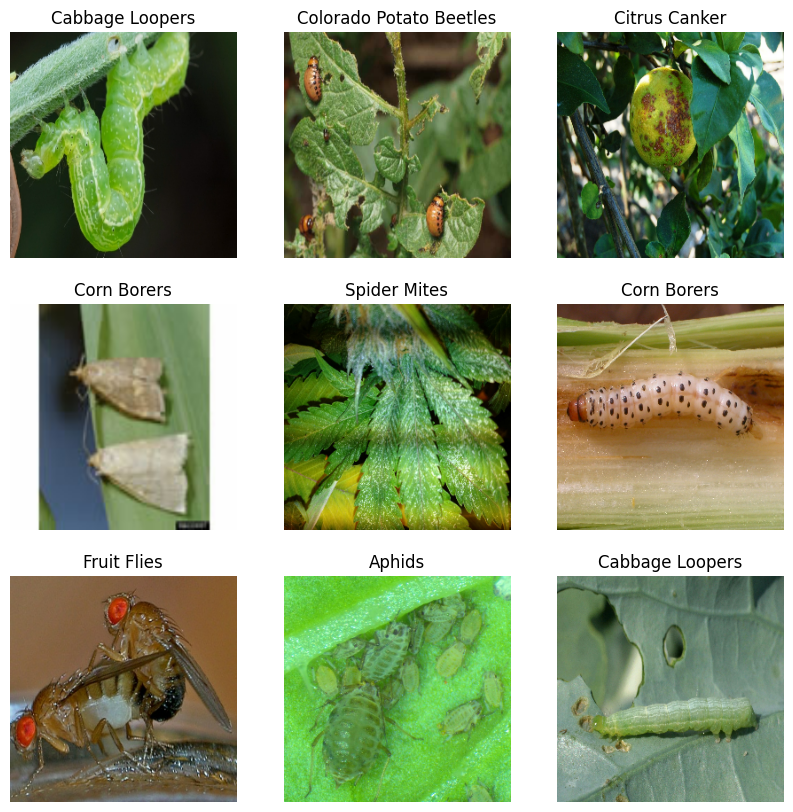

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")
plt.show()


## Dimensão das imagens

In [16]:
import tensorflow as tf
import pathlib

data_dir = pathlib.Path("farm_insects")
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=(224, 224))

# Get image dimensions
image_shapes = set()
for images, _ in data:
    for image in images:
        image_shapes.add(image.shape)

print("Different image shapes found in the dataset:")
print(image_shapes)

# Check if images have consistent dimensions
if len(image_shapes) == 1:
    print("All images have consistent dimensions.")
    image_height, image_width, num_channels = image_shapes.pop()
else:
    print("Images have varying dimensions.")
    # Decide on a common size for resizing, e.g., (height, width)
    common_image_size = (224, 224)  # You can change this to your preferred size
    image_height, image_width, num_channels = common_image_size


Found 1591 files belonging to 15 classes.
Different image shapes found in the dataset:
{TensorShape([224, 224, 3])}
All images have consistent dimensions.


## Data augmentaion

A técnica de data augmentation que foi experimentada está documentada abaixo. Entretanto, não foi utilizada para a continuidado dos experimentos pois os testes realizados com o conjunto de treinamento após a aplicação de data augmentation apresentou resultados muito inferiores com relação aos resultados obtidos com o conjunto de treino sem modificações.

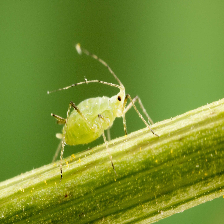

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = 'farm_insects/Aphids/Image_1.jpeg'
img = image.load_img(img_path, target_size=(224, 224, 3))
display(img)


In [ ]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

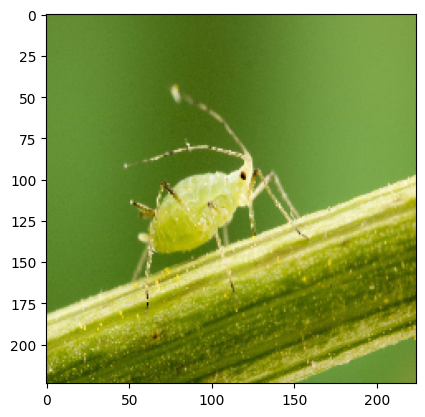

In [ ]:
result = rescale(img)
plt.imshow(result)

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [ ]:
# Add the image to a batch.
image = tf.expand_dims(result, 0)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

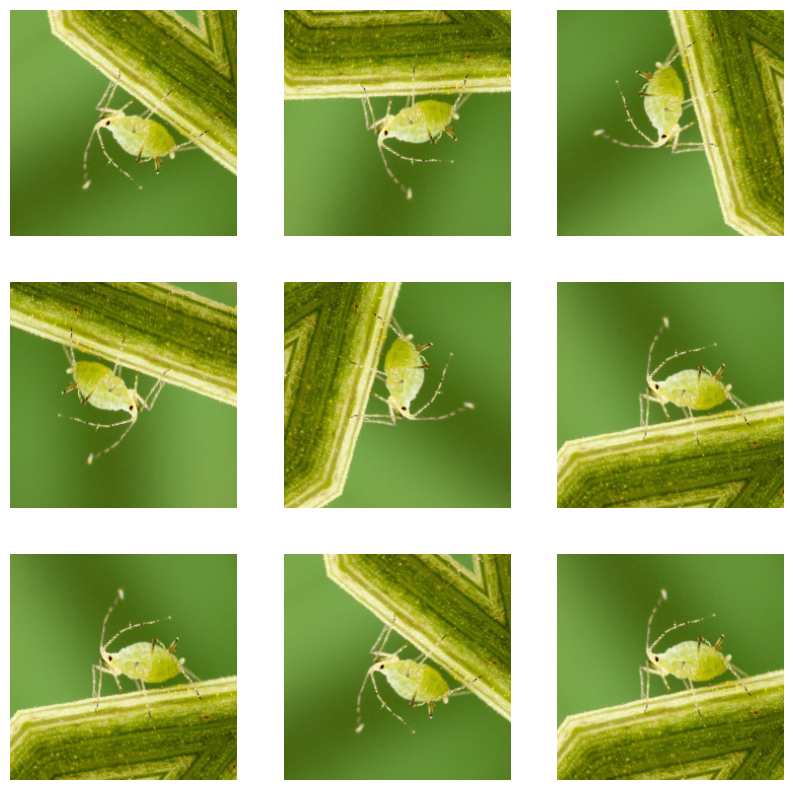

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Aplicando data augmentation em todo o dataset

In [ ]:
train_ds = train_ds.map(
  lambda x, y: (rescale(x, training=True), y))

In [ ]:
train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Treinamento
- Fazer o treinamento de uma rede VGG pré treinada no ImageNet (transfer learning)
- Fazer o treinamento de uma rede VGG com o dataset Dangerous Farm Insects
- Fazer o treinamento de uma MobileNet (pois é econômica de recursos) ou densenet

## VGG - Transfer learning

Aplicando o passo a passo da documentação do Keras [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow)

In [17]:
base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

58889256/58889256 [==============================] - 0s 0us/step


In [18]:
base_model.trainable = False

In [19]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with 15 neurons
outputs = keras.layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [20]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
history_vgg_tl = model.fit(train_ds, epochs=10)

Epoch 1/10
40/40 [==============================] - 41s 214ms/step - loss: 8.7912 - sparse_categorical_accuracy: 0.0998
Epoch 2/10
40/40 [==============================] - 5s 122ms/step - loss: 4.4851 - sparse_categorical_accuracy: 0.3024
Epoch 3/10
40/40 [==============================] - 5s 124ms/step - loss: 2.9497 - sparse_categorical_accuracy: 0.4297
Epoch 4/10
40/40 [==============================] - 5s 126ms/step - loss: 2.1482 - sparse_categorical_accuracy: 0.5444
Epoch 5/10
40/40 [==============================] - 5s 127ms/step - loss: 1.6590 - sparse_categorical_accuracy: 0.6151
Epoch 6/10
40/40 [==============================] - 5s 130ms/step - loss: 1.3329 - sparse_categorical_accuracy: 0.6575
Epoch 7/10
40/40 [==============================] - 5s 129ms/step - loss: 1.0699 - sparse_categorical_accuracy: 0.7164
Epoch 8/10
40/40 [==============================] - 5s 131ms/step - loss: 0.8917 - sparse_categorical_accuracy: 0.7573
Epoch 9/10
40/40 [=============================

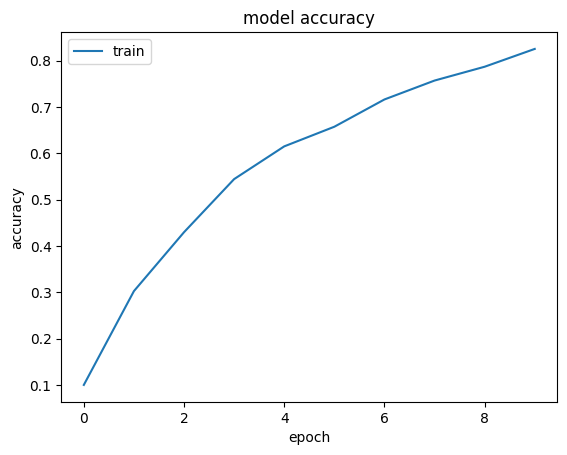

In [21]:
plt.plot(history_vgg_tl.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

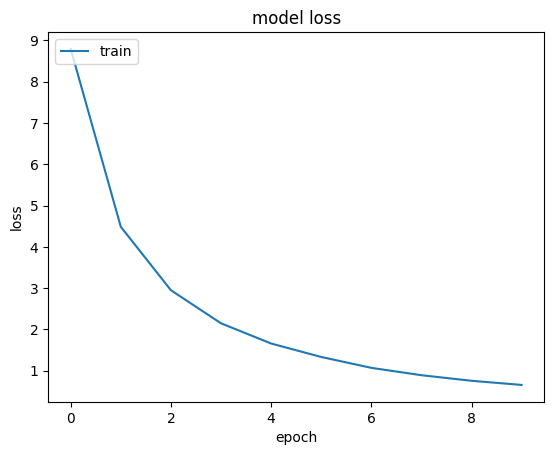

In [22]:
plt.plot(history_vgg_tl.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Fine tuning

In [23]:
base_model.trainable = True

In [24]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
history_fine_tuning_tl = model.fit(train_ds, epochs=15)

Epoch 1/15
40/40 [==============================] - 37s 592ms/step - loss: 0.7082 - sparse_categorical_accuracy: 0.7855
Epoch 2/15
40/40 [==============================] - 17s 425ms/step - loss: 0.2651 - sparse_categorical_accuracy: 0.9277
Epoch 3/15
40/40 [==============================] - 17s 426ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.9592
Epoch 4/15
40/40 [==============================] - 17s 428ms/step - loss: 0.1082 - sparse_categorical_accuracy: 0.9741
Epoch 5/15
40/40 [==============================] - 17s 436ms/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9780
Epoch 6/15
40/40 [==============================] - 17s 431ms/step - loss: 0.1222 - sparse_categorical_accuracy: 0.9756
Epoch 7/15
40/40 [==============================] - 17s 427ms/step - loss: 0.0952 - sparse_categorical_accuracy: 0.9796
Epoch 8/15
40/40 [==============================] - 17s 429ms/step - loss: 0.0730 - sparse_categorical_accuracy: 0.9835
Epoch 9/15
40/40 [======================

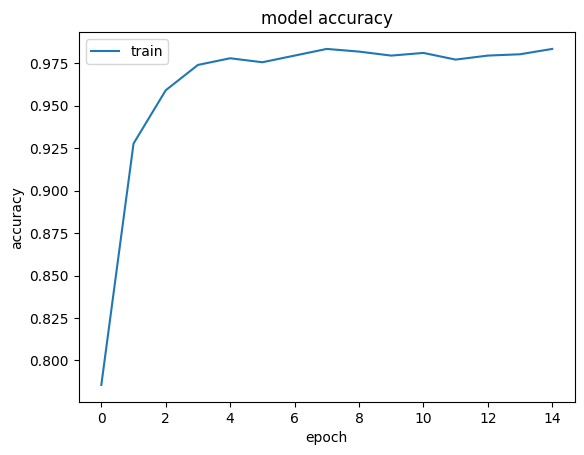

In [25]:
plt.plot(history_fine_tuning_tl.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

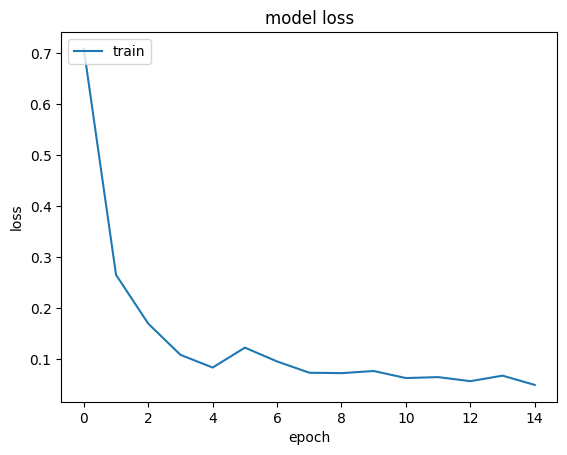

In [26]:
plt.plot(history_fine_tuning_tl.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()